
# Preliminaries




## Importing libraries



In [1]:
import numpy
from matplotlib import pyplot
from ipywidgets import interact
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy import stats


## Information from literature



In [1]:
exposure_to_rash = 17
rash = 5.5
# Source: https://www.cdc.gov/vaccines/pubs/pinkbook/downloads/meas.pdf

infectious_without_rash = 4
latent_period = exposure_to_rash - infectious_without_rash
infectious_period = rash + 2*infectious_without_rash
# Source: https://www.cdc.gov/measles/about/transmission.html

VE = 0.93
# Source: https://www.cdc.gov/measles/vaccination.html

coverage = 0.14
population = 32630 # Amish population
outbreak_final_size = 383
epidemic_peak = 17
# Source: https://www.nejm.org/doi/pdf/10.1056/NEJMoa1602295


## Measles model



In [1]:
def f(x, t, alpha, beta, gamma):
    S = x[0]
    L = x[1]
    I = x[2]
    R = x[3]

    N = S + L + I + R

    dS_dt = - beta*I/N*S
    dL_dt = (beta*I/N)*S - alpha*L
    dI_dt = alpha*L - gamma*I
    dR_dt = gamma*I

    return [dS_dt, dL_dt, dI_dt, dR_dt]


def compute_ODE(alpha, beta, gamma, p, N):

    S0 = (1-p)*N - 1
    L0 = 0
    I0 = 1
    R0 = p*N

    ts = numpy.arange(0, 366)
    x0 = [S0, L0, I0, R0]
    xs = odeint(f, x0, ts, (alpha, beta, gamma))

    return xs


def plot(xs):
    ts = numpy.arange(0, 366)
    pyplot.plot(ts, xs[:, 2])
    pyplot.legend(["Infected"])
    pyplot.xlabel("Time (days)")
    pyplot.ylim([0, 400])
    pyplot.show()

    pyplot.plot(ts, xs[:, [0, -1]])
    pyplot.legend(["Susceptible", "Recovered"])
    pyplot.xlabel("Time (days)")
    pyplot.ylim([0, numpy.sum(xs[0])])
    pyplot.show()


def print_info(xs):
    final_size = xs[-1, -1] - xs[0, -1]
    print("Final size outbreak: {:.0f}".format(final_size))


def model(beta,
          alpha=1/latent_period,
          gamma=1/infectious_period,
          p=coverage*VE,
          N=population):
    xs = compute_ODE(alpha, beta, gamma, p, N)
    plot(xs)
    print_info(xs)


# Estimating $\beta$ with $\mathcal{R}_{0}$




## Estimating $\beta$ with a single $\mathcal{R}_{0}$



In [1]:
R_0 = 15
bar_beta = R_0 / infectious_period
bar_beta

In [1]:
model(bar_beta)


## Estimating $\beta$ with an $\mathcal{R}_{0}$ range



In [1]:
R_0_range = [12, 18]
bar_beta_range = [R_0_range[i] / infectious_period for i in [0, 1]]
bar_beta_range

In [1]:
[model(beta) for beta in bar_beta_range]

Back to presentation




# Adjusting $\beta$ to match epidemic size



In [1]:
interact(model, beta=(0.01, 1.1, 0.001))

Back to presentation




# Bisection approach



In [1]:
def compute_final_size(beta, alpha=1/latent_period,
                       gamma=1/infectious_period, p=coverage*VE,
                       N=population):
    xs = compute_ODE(alpha, beta, gamma, p, N)
    return xs[-1, -1] - xs[0, -1]

In [1]:
compute_final_size(0.8)

In [1]:
compute_final_size(0.01)

In [1]:
tolerance = 0.5

beta1 = 0.1
beta2 = 0.8

bar_beta = (beta1 + beta2)/2

while numpy.abs(compute_final_size(bar_beta) - outbreak_final_size) > tolerance:
    if compute_final_size(bar_beta) < outbreak_final_size:
        beta1 = bar_beta
    else:
        beta2 = bar_beta

    bar_beta = (beta1 + beta2)/2

In [1]:
bar_beta

In [1]:
compute_final_size(bar_beta)

In [1]:
model(bar_beta)

Back to presentation




# Least squares method



In [1]:
def function_to_minize(variables):
    beta = variables[0]
    N = variables[1]

    final_size = compute_final_size(beta=beta, N=N)
    return (final_size-outbreak_final_size)**2

minimize(function_to_minize, [0.9, 400])

In [1]:
model(beta=2.34228733, N=440.33110651)

How about another initial guess



In [1]:
minimize(function_to_minize, [0.5, 3000])

In [1]:
model(beta=1.21481947e-01, N=2.93685955e+03)

Back to the presentation




# Informing on the peak of the epidemic



In [1]:
def print_info(xs):
    final_size = xs[-1, -1] - xs[0, -1]
    print("Final size outbreak: {:.0f}".format(final_size))

    peak = numpy.max(xs[:, 2])
    print("Epidemic peak: {:.0f}".format(peak))

In [1]:
model(beta=2.34228733, N=440)

Back to the presentation




# Least squares sum



In [1]:
def compute_peak(beta, alpha=1/latent_period,
                 gamma=1/infectious_period, p=coverage*VE,
                 N=population):
    xs = compute_ODE(alpha, beta, gamma, p, N)
    return numpy.max(xs[:, 2])

In [1]:
def function_to_minize(variables):
    beta = variables[0]
    N = variables[1]

    final_size = compute_final_size(beta=beta, N=N)
    peak = compute_peak(beta=beta, N=N)
    return (final_size-outbreak_final_size)**2 + (peak-epidemic_peak)**2

minimize(function_to_minize, [2.3, 440])

In [1]:
model(beta=2.41907583e-01, N=4.39793937e+02)

Back to presentation




# Penalizing least squares sum



In [1]:
def function_to_minize(variables):
    beta = variables[0]
    N = variables[1]

    final_size = compute_final_size(beta=beta, N=N)
    peak = compute_peak(beta=beta, N=N)
    return (final_size-outbreak_final_size)**2 + 20*(peak-epidemic_peak)**2

minimize(function_to_minize, [2.3, 440])


## Solving negative values problem



In [1]:
def function_to_minize(variables):
    beta = variables[0]
    N = variables[1]

    final_size = compute_final_size(beta=beta, N=N)
    peak = compute_peak(beta=beta, N=N)
    return (final_size-outbreak_final_size)**2 + 20*(peak-epidemic_peak)**2

minimize(function_to_minize, [2.3, 440], bounds=[(0, 10), (outbreak_final_size, population)])

In [1]:
model(beta=1.36960311e-01, N=7.53439081e+02)


## Did we solve the multiple solution problem?



In [1]:
minimize(function_to_minize, [0.5, 3000])

In [1]:
model(beta=1.36883891e-01, N=7.55183251e+02)

Back to presentation




# Maximum likelihood



In [31]:
shape = 1547.59
scale = 0.24748
stats.gamma.mean(shape, scale=scale)

382.9975732

In [32]:
stats.gamma.cdf(400, shape, scale=scale) - stats.gamma.cdf(360, shape, scale=scale)

0.9500154195518774

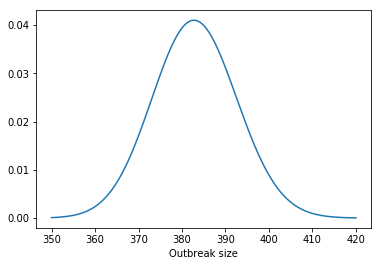

In [33]:
ys = numpy.linspace(350, 420, 1000)
pyplot.plot(ys, stats.gamma.pdf(ys, shape, scale=scale))
pyplot.xlabel("Outbreak size")
pyplot.show()

Back to presentation

